In [5]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.cluster import KMeans
import pickle  # For saving and loading the model
import random  # For introducing randomness in recommendations

#############################
# Pipeline 1: Genetic Model (using RandomForestClassifier)
#############################

# Load genetic dataset (assumes comma-delimited)
genetic_file_path = r"C:\Users\trejan\Desktop\Sem 2\Machine Learning\model\new_genetic_profiles.csv"
genetic_df = pd.read_csv(genetic_file_path)
genetic_df.columns = genetic_df.columns.str.strip()
genetic_df.fillna("None", inplace=True)

# Convert Obesity_Risk_Score into categories (Low, Medium, High)
genetic_df['Obesity_Risk_Category'] = pd.cut(
    genetic_df['Obesity_Risk_Score'],
    bins=[0, 0.5, 0.8, 1],
    labels=['Low', 'Medium', 'High']
)

# Initialize dictionary to store LabelEncoders
label_encoders = {}

# Encode categorical variables (Diet_Type, Physical_Activity)
for col in ["Diet_Type", "Physical_Activity"]:
    le = LabelEncoder()
    genetic_df[col] = le.fit_transform(genetic_df[col])
    label_encoders[col] = le

# Encode gene variant columns as strings (so that "None" is encoded too)
variant_columns = ["MC4R_Variant", "PPARG_Variant", "FTO_Variant", "LEPR_Variant"]
for col in variant_columns:
    genetic_df[col] = genetic_df[col].astype(str)
    le = LabelEncoder()
    genetic_df[col] = le.fit_transform(genetic_df[col])
    label_encoders[col] = le

# Define features and target for the genetic model
features = [
    "Age", "BMI", "Physical_Activity", "Diet_Type",
    "MC4R_Present", "MC4R_Variant",
    "PPARG_Present", "PPARG_Variant",
    "FTO_Present", "FTO_Variant",
    "LEPR_Present", "LEPR_Variant"
]
target = "Obesity_Risk_Category"

X_gen = genetic_df[features]
y_gen = genetic_df[target]

# Encode target labels (Low, Medium, High)
target_le = LabelEncoder()
y_encoded = target_le.fit_transform(y_gen)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_gen, y_encoded, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test_scaled)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=target_le.classes_))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

#############################
# Pipeline 2: Meal Recommendation
#############################

# Load the meal dataset (assumed to be comma-delimited)
meal_file_path = r"C:\Users\trejan\Desktop\Sem 2\Machine Learning\model\train.csv"
meal_df = pd.read_csv(meal_file_path)

# Preprocess nutritional features; these columns should exist in your meal dataset
nutritional_features = meal_df[['Energy_kcal', 'Protein_g', 'Fat_g', 'Carb_g']]
scaler_meal = StandardScaler()
nutritional_features_scaled = scaler_meal.fit_transform(nutritional_features)

# Cluster meals using KMeans (e.g., 10 clusters)
num_clusters = 10
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
meal_df['Meal_Cluster'] = kmeans.fit_predict(nutritional_features_scaled)

# Define a meal recommendation function
def recommend_meals(user_profile, meal_df, model, target_le, scaler, num_meals=5):
    """
    user_profile: dict with genetic feature values (original, unencoded)
    model: trained scikit-learn model
    target_le: LabelEncoder for the target risk category
    scaler: StandardScaler fitted on genetic features
    """
    # Convert user_profile into a DataFrame
    user_profile_df = pd.DataFrame([user_profile])
    
    # Encode categorical features using stored encoders
    for col in ["Diet_Type", "Physical_Activity"]:
        if col in user_profile_df.columns:
            le = label_encoders[col]
            user_profile_df[col] = le.transform(user_profile_df[col])
    for col in variant_columns:
        if col in user_profile_df.columns:
            le = label_encoders[col]
            user_profile_df[col] = le.transform(user_profile_df[col].astype(str))
    
    # Ensure the user profile contains all required features; fill missing with 0
    missing_cols = set(features) - set(user_profile_df.columns)
    for col in missing_cols:
        user_profile_df[col] = 0
    user_profile_df = user_profile_df[features]
    
    # Scale the user profile using the same scaler as training
    user_profile_scaled = scaler.transform(user_profile_df)
    
    # Predict obesity risk using the model
    predicted_category = model.predict(user_profile_scaled)[0]
    predicted_label = target_le.inverse_transform([predicted_category])[0]
    print(f"\nPredicted Obesity Risk Category: {predicted_label}")
    
    # Define cluster preferences based on predicted risk (example logic)
    if predicted_label == 'Low':
        preferred_clusters = [0, 1, 2, 3]  # Broaden the cluster selection
        sort_by = random.choice(['Protein_g', 'Energy_kcal'])  # Randomize sorting
        ascending = random.choice([True, False])  # Randomize order
    elif predicted_label == 'Medium':
        preferred_clusters = [4, 5, 6, 7]  # Broaden the cluster selection
        sort_by = random.choice(['Energy_kcal', 'Fat_g'])  # Randomize sorting
        ascending = random.choice([True, False])  # Randomize order
    else:
        preferred_clusters = [8, 9, 0, 1]  # Broaden the cluster selection
        sort_by = random.choice(['Energy_kcal', 'Carb_g'])  # Randomize sorting
        ascending = random.choice([True, False])  # Randomize order
    
    # Filter and sort meals from the preferred clusters
    recommended_meals = meal_df[meal_df['Meal_Cluster'].isin(preferred_clusters)]
    recommended_meals = recommended_meals.sample(frac=1).reset_index(drop=True)  # Shuffle the meals
    recommended_meals = recommended_meals.sort_values(by=sort_by, ascending=ascending)
    
    print("\nRecommended Meals:")
    print(recommended_meals[['Descrip', 'Energy_kcal', 'Protein_g', 'Fat_g', 'Carb_g']].head(num_meals))

# Example new genetic profile for meal recommendation
new_profile = {
    "Age": 35,
    "BMI": 28.5,
    "Physical_Activity": "Low",      # Original string (will be encoded)
    "Diet_Type": "High-Fat",           # Original string (will be encoded)
    "MC4R_Present": 0,
    "MC4R_Variant": "rs17782313_TT",
    "PPARG_Present": 1,
    "PPARG_Variant": "rs1801282_CG",
    "FTO_Present": 0,
    "FTO_Variant": "rs9939609_AT",
    "LEPR_Present": 1,
    "LEPR_Variant": "rs1137101_AG"
}

# Get meal recommendations using the model
recommend_meals(new_profile, meal_df, rf_model, target_le, scaler, num_meals=5)

#############################
# Save the Model and Pipeline Using Pickle
#############################

# Save the model, scaler, and encoders
with open("model_pipeline.pkl", "wb") as f:
    pickle.dump({
        "model": rf_model,
        "scaler": scaler,
        "label_encoders": label_encoders,
        "target_le": target_le
    }, f)

# Load the model and pipeline
with open("model_pipeline.pkl", "rb") as f:
    pipeline = pickle.load(f)

# Access the saved components
loaded_model = pipeline["model"]
loaded_scaler = pipeline["scaler"]
loaded_label_encoders = pipeline["label_encoders"]
loaded_target_le = pipeline["target_le"]

Classification Report:
              precision    recall  f1-score   support

        High       0.89      0.93      0.91        88
         Low       0.76      0.88      0.81       182
      Medium       0.71      0.53      0.61       130

    accuracy                           0.78       400
   macro avg       0.79      0.78      0.78       400
weighted avg       0.77      0.78      0.77       400

Confusion Matrix:
[[ 82   0   6]
 [  0 160  22]
 [ 10  51  69]]

Predicted Obesity Risk Category: High

Recommended Meals:
                                                Descrip  Energy_kcal  \
0     Chicken, broilers or fryers, breast, meat only...        137.0   
2224  Veal, loin, separable lean and fat, cooked, br...        284.0   
2222  Chicken, broilers or fryers, leg, meat only, c...        185.0   
2221  Beef, bottom sirloin, tri-tip roast, separable...        193.0   
2213  Beef, top sirloin, steak, separable lean only,...        187.0   

      Protein_g  Fat_g  Carb_g  
0      

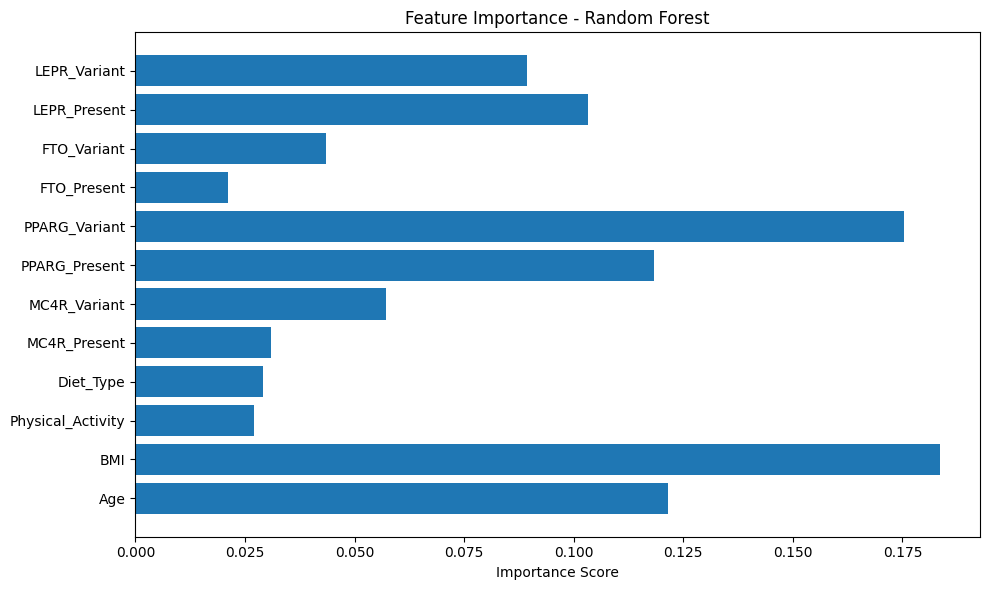

In [21]:
import matplotlib.pyplot as plt

# Feature Importance from Random Forest
importances = rf_model.feature_importances_
feature_names = X_gen.columns

# Plot Feature Importance
plt.figure(figsize=(10,6))
plt.barh(feature_names, importances)
plt.title("Feature Importance - Random Forest")
plt.xlabel("Importance Score")
plt.tight_layout()

# Save the plot
plt.savefig(r'C:\Users\trejan\Desktop\XAI\FIRSTB\rf_feature_importance.png')

# Show the plot
plt.show()


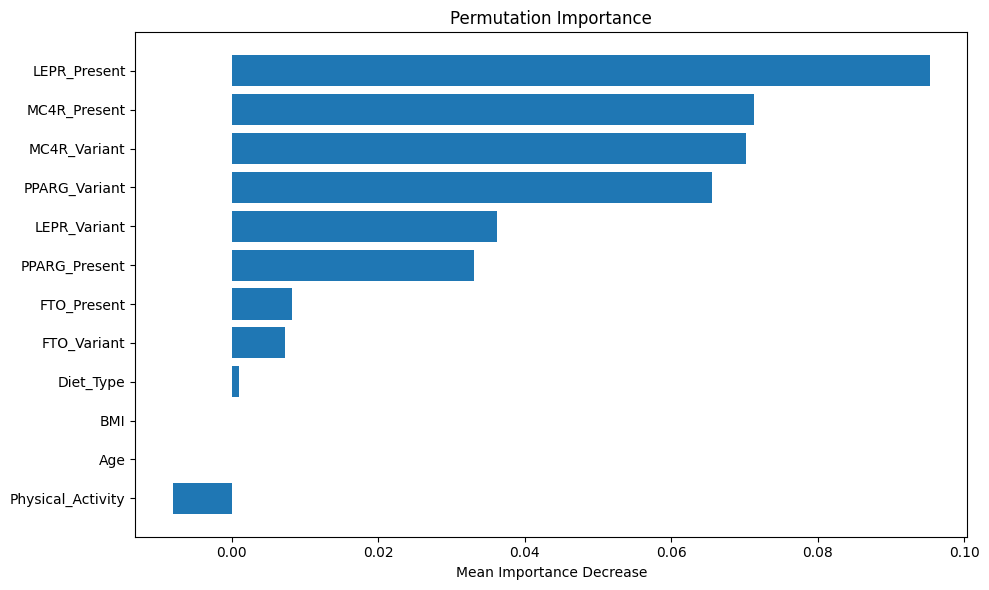

In [22]:
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

# Assuming you used X_gen.columns while training the model
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_gen.columns)

# Compute permutation importance with valid feature names
perm_importance = permutation_importance(rf_model, X_test_scaled_df, y_test, n_repeats=10, random_state=42)

# Plot Permutation Importance
sorted_idx = perm_importance.importances_mean.argsort()
plt.figure(figsize=(10,6))
plt.barh(X_test_scaled_df.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.title("Permutation Importance")
plt.xlabel("Mean Importance Decrease")
plt.tight_layout()

# Save the plot
plt.savefig(r'C:\Users\trejan\Desktop\XAI\FIRSTB\permutation_importance.png')

# Show the plot
plt.show()


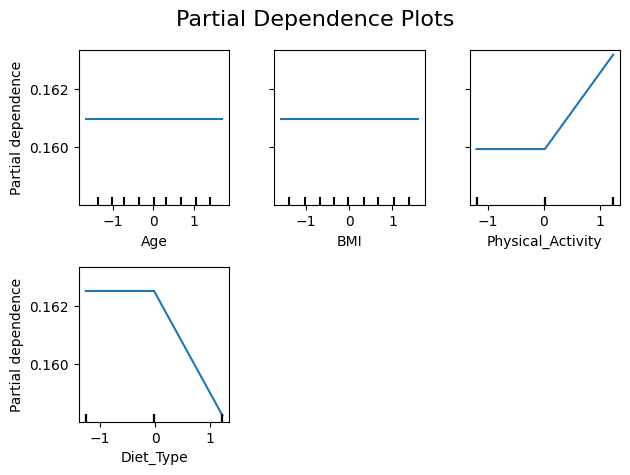

In [24]:
import pandas as pd

# Create DataFrames with feature names
X_train_df = pd.DataFrame(X_train_scaled, columns=feature_names)
X_test_df = pd.DataFrame(X_test_scaled, columns=feature_names)

# Generate PDP
display = PartialDependenceDisplay.from_estimator(
    rf_model,
    X_train_df,
    features=important_features,
    feature_names=feature_names,
    target=0
)

# Add spacing and title
display.figure_.suptitle("Partial Dependence Plots", fontsize=16)
plt.subplots_adjust(hspace=0.4, wspace=0.3)  # Adjust these values for more/less spacing
plt.tight_layout()
plt.show()
